# Parse gmail `.mbox` file

This notebook takes an archive of gmail messages and from them extracts a value for the time between when a conversation involving the account holder begins, and when they first reply, or join the conversation.

To download an `.mbox` file from gmail, containing an archive of your email messages, visit https://takeout.google.com/settings/takeout. (This is valid as of Feb 2016 - however this may not always be the case!)

A lot of the message headers are described here: http://www.ietf.org/rfc/rfc2076.txt

The python standard library has a module for dealing with this type of file, which we'll draw on extensively, along with pandas.

In [5]:
%pylab inline
import mailbox
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
mb = mailbox.mbox('All mail Including Spam and Trash.mbox')

### Step 1: extract relevant information from mbox file

In this analysis we will want to group messages according to the conversation they are a part of. Gmail makes this easy for us as one of the message attributes, `X-GM-THRID`, is a unique thread identifier, assigned by google as it compiles messages together into conversation threads. 

We'll also want the field `X-Gmail-Labels`, which will tell us if the message is categorized as *Sent*, so that we can distinguish it from messages that were recieved by the account holder. Lastly, we want the date and time that the message was sent: `Date`. 

We don't need any information about the content of the message, or even who it was to or from.

In [3]:
keys = ['Date', 'X-Gmail-Labels', 'X-GM-THRID']
message_list = []

for message in mb.itervalues():
    dmessage = dict(message.items())
    message_list.append({key:dmessage[key] if key in dmessage.keys() else '' for key in keys})

print len(message_list), 'messages'
print '**'*50
message_list[:3]

127005 messages
****************************************************************************************************


[{'Date': 'Mon, 07 Sep 2015 23:45:16 +0000',
  'X-GM-THRID': '1511700066770539101',
  'X-Gmail-Labels': 'Important'},
 {'Date': 'Wed, 9 Sep 2015 08:56:18 -0400',
  'X-GM-THRID': '1511700066770539101',
  'X-Gmail-Labels': 'Important'},
 {'Date': 'Wed, 9 Sep 2015 09:53:19 +0000',
  'X-GM-THRID': '1511828916942046097',
  'X-Gmail-Labels': 'Important'}]

In [4]:
messages = pd.DataFrame(message_list)
messages.index = messages['Date'].apply(lambda x: pd.to_datetime(x, errors='coerce'))
messages.drop(['Date'], axis=1, inplace=True)
print messages.shape
messages.head()

(127005, 2)


,X-GM-THRID,X-Gmail-Labels
Date,,
2015-09-07 23:45:16,1511700066770539101,Important
2015-09-09 12:56:18,1511700066770539101,Important
2015-09-09 09:53:19,1511828916942046097,Important
2015-09-09 01:27:24,1511797100113048401,Important
2015-09-09 00:08:23,1511793662558459198,Unread


### Step 2: group the messages by thread

We'll begin by grouping the messages into their various threads.

32966 threads total


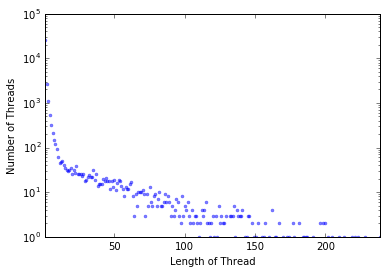

In [9]:
conversation_list = []
threads = messages.groupby(by='X-GM-THRID')
print len(threads), 'threads total'

counts = threads.aggregate('count')['X-Gmail-Labels'].value_counts()
counts.plot(logy=True, linewidth=0, marker='.', alpha=.5)
plt.ylabel('Number of Threads')
plt.xlabel('Length of Thread')


### Step 3: find relevant timestamps

To simplify our analysis, we will assume that we are interested in the time between when a thread starts and when the account holder joins the conversation by sending their first message in the thread. To find these times, we sort the thread on its index, and take the first message time as the start of the conversation.

Then we filter to just the messages labeled *Sent*, and (as they are still sorted) take the first of these.

In [10]:
for name, group in threads:
    if len(group) > 1:
        if 'Sent' in group['X-Gmail-Labels'].values:
            group.sort_index(inplace=True)
            tstart = group.index[0]
            tjoin = group[group['X-Gmail-Labels']=='Sent'].index[0]
            conversation_list.append({'tstart':tstart, 'tjoin':tjoin})

conversations = pd.DataFrame(conversation_list)
print conversations.shape
conversations.head()

(1873, 2)


/Users/houghton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,tjoin,tstart
0,2005-04-01 05:02:38,2005-04-01 05:02:38
1,2005-05-04 03:21:04,2005-05-03 22:38:19
2,2005-05-08 22:17:15,2005-05-08 22:17:15
3,2005-05-19 18:40:44,2005-05-19 18:40:44
4,2005-05-31 15:37:58,2005-05-31 15:37:58


### Step 4: Calculate the time delta

We now can subtract the one from the other, and convert the result into units of days.

In [13]:
delta = conversations['tjoin']-conversations['tstart']
days = 1.* delta.dt.total_seconds() / 3600 / 24
days.head()

0    0.000000
1    0.196354
2    0.000000
3    0.000000
4    0.000000
dtype: float64

### Step 5: Filter out threads started by the account holder

When the time difference between the first message in the thread and the first message sent by the account holder is zero, then we assume that the account holder initiated the thread. As we are interested in seeing how the account holder deals with emails they recieve, we filter these out.

In [19]:
days = days[days>0]
days = days.reset_index()[0]
days.head()

0    0.196354
1    0.076539
2    0.352731
3    0.321343
4    0.720741
Name: 0, dtype: float64

### Step 6: Save to csv

In [20]:
days.to_csv('days_to_join_conversation.csv')